<h1><center>Car Features and MSRP</h1>

One of the most significant purchases in many people's lives is a car. Not only is it one of the most expensive purchases (after a house), it is one that is often used daily. Whether buying a car new or used, a saavy consumer will do some research to determine the best fit, from both a feature and value standpoint. Conversely, it is important for car manufacturers to understand what consumers value to determine a fair Manufacturer Suggested Retail Price (MSRP). This study will investigate the relationship between a car's features and its MSRP.

### Data Loading and Cleaning

In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this Jupyter notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
import pandas as pd
import scipy
import numpy as np
import math
import datetime

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [104]:
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from regressors import stats,plots

from collections import Counter

The original data set used was scraped from www.thecarconnection.com and collected by nicolas-gervais in the r/datasets on Reddit avaiable here: https://www.reddit.com/r/datasets/comments/b6rcwv/i_scraped_32000_cars_including_the_price_and_115/. This set includes all vehicle makes and models available without adjustment for number of vehicles sold so is not necessarily representative of the vehicles actually found on the road but rather this theoretical set.

In [4]:
df = pd.read_csv('../../data/carspecs.csv',low_memory=False)
df = df.T
df.columns = df.iloc[0]
df = df[1:]

In [5]:
df.head(5)

Unnamed: 0,MSRP,Gas Mileage,Engine,EPA Class,Style Name,Drivetrain,Passenger Capacity,Passenger Doors,Body Style,Transmission,EPA Classification,Base Curb Weight (lbs),Front Hip Room (in),Front Leg Room (in),Second Shoulder Room (in),Passenger Volume (ft³),Second Head Room (in),Front Shoulder Room (in),Second Hip Room (in),Front Head Room (in),Second Leg Room (in),Wheelbase (in),Min Ground Clearance (in),"Track Width, Front (in)","Width, Max w/o mirrors (in)","Track Width, Rear (in)","Height, Overall (in)",Cargo Volume to Seat 1 (ft³),Cargo Volume to Seat 2 (ft³),Cargo Volume to Seat 3 (ft³),"Fuel Tank Capacity, Approx (gal)",Fuel Economy Est-Combined (MPG),EPA Fuel Economy Est - City (MPG),EPA Fuel Economy Est - Hwy (MPG),Engine Order Code,SAE Net Torque @ RPM,Fuel System,Engine Type,SAE Net Horsepower @ RPM,Displacement,...,"Steering Ratio (:1), On Center","Steering Ratio (:1), At Lock",Spare Tire Capacity (lbs),Front Tire Capacity (lbs),Revolutions/Mile @ 45 mph - Spare,Revolutions/Mile @ 45 mph - Front,Rear Tire Capacity (lbs),Revolutions/Mile @ 45 mph - Rear,Axle Capacity - Front (lbs),Spring Capacity - Front (lbs),Axle Capacity - Rear (lbs),Spring Capacity - Rear (lbs),Maximum Alternator Watts,Fifth Wheel Hitch - Max Trailer Wt. (lbs),Fifth Wheel Hitch - Max Tongue Wt. (lbs),"Length, Overall w/o rear bumper (in)",Front Bumper to Back of Cab (in),"Frame Width, Rear (in)",Cab to Axle (in),"Overhang, Rear w/o bumper (in)",Ground to Top of Frame (in),Cab to End of Frame (in),"Cargo Box Width @ Top, Rear (in)",Cargo Volume (ft³),Cargo Box Width @ Floor (in),Ext'd Cab Cargo Volume (ft³),Cargo Box Length @ Floor (in),Tailgate Width (in),Drivetrain Note,Emissions Note,Fourth Hip Room (in),Fourth Leg Room (in),Fourth Shoulder Room (in),Fourth Head Room (in),Fifth Shoulder Room (in),Fifth Head Room (in),Fifth Hip Room (in),Fifth Leg Room (in),Corrosion Note,Hybrid/Electric Components Note
2019 Acura RDX Specs: FWD w/Technology Pkg,"$40,600",22 mpg City/28 mpg Hwy,"Turbo Premium Unleaded I-4, 2.0 L",Small Sport Utility Vehicles 2WD,FWD w/Technology Pkg,Front Wheel Drive,5,4,Sport Utility,Transmission: 10-Speed Automatic -inc: sequent...,Small Sport Utility Vehicles 2WD,3790,55,41.6,56.6,104,38.3,59.7,49.9,39.6,38.4,108.3,5.7,64.2,74.8,64.7,65.7,58.9,29.5,29.5,17.1,24,22,28,NaN,280 @ 1600,Gasoline Direct Injection,Turbo Premium Unleaded I-4,272 @ 6500,2.0 L/122,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019 Acura RDX Specs: FWD w/Advance Pkg,"$45,500",22 mpg City/28 mpg Hwy,"Turbo Premium Unleaded I-4, 2.0 L",Small Sport Utility Vehicles 2WD,FWD w/Advance Pkg,Front Wheel Drive,5,4,Sport Utility,Transmission: 10-Speed Automatic -inc: sequent...,Small Sport Utility Vehicles 2WD,3829,55,41.6,56.6,104,38.3,59.7,49.9,39.6,38.4,108.3,5.7,64.2,74.8,64.7,65.7,58.9,29.5,29.5,17.1,24,22,28,NaN,280 @ 1600,Gasoline Direct Injection,Turbo Premium Unleaded I-4,272 @ 6500,2.0 L/122,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019 Acura RDX Specs: FWD w/A-Spec Pkg,"$43,600",22 mpg City/27 mpg Hwy,"Turbo Premium Unleaded I-4, 2.0 L",Small Sport Utility Vehicles 2WD,FWD w/A-Spec Pkg,Front Wheel Drive,5,4,Sport Utility,Transmission: 10-Speed Automatic -inc: sequent...,Small Sport Utility Vehicles 2WD,3821,55,41.6,56.6,104,38.3,59.7,49.9,39.6,38.4,108.3,5.7,64.2,74.8,64.7,65.7,58.9,29.5,29.5,17.1,24,22,27,NaN,280 @ 1600,Gasoline Direct Injection,Turbo Premium Unleaded I-4,272 @ 6500,2.0 L/122,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019 Acura RDX Specs: FWD,"$37,400",22 mpg City/28 mpg Hwy,"Turbo Premium Unleaded I-4, 2.0 L",Small Sport Utility Vehicles 2WD,FWD,Front Wheel Drive,5,4,Sport Util

In [6]:
df.columns.values

array(['MSRP', 'Gas Mileage', 'Engine', 'EPA Class', 'Style Name',
       'Drivetrain', 'Passenger Capacity', 'Passenger Doors',
       'Body Style', 'Transmission', 'EPA Classification',
       'Base Curb Weight (lbs)', 'Front Hip Room (in)',
       'Front Leg Room (in)', 'Second Shoulder Room (in)',
       'Passenger Volume (ft³)', 'Second Head Room (in)',
       'Front Shoulder Room (in)', 'Second Hip Room (in)',
       'Front Head Room (in)', 'Second Leg Room (in)', 'Wheelbase (in)',
       'Min Ground Clearance (in)', 'Track Width, Front (in)',
       'Width, Max w/o mirrors (in)', 'Track Width, Rear (in)',
       'Height, Overall (in)', 'Cargo Volume to Seat 1 (ft³)',
       'Cargo Volume to Seat 2 (ft³)', 'Cargo Volume to Seat 3 (ft³)',
       'Fuel Tank Capacity, Approx (gal)',
       'Fuel Economy Est-Combined (MPG)',
       'EPA Fuel Economy Est - City (MPG)',
       'EPA Fuel Economy Est - Hwy (MPG)', 'Engine Order Code',
       'SAE Net Torque @ RPM', 'Fuel System', 'Engine

Of the 234 features originally included in the data set, 35 of the most available and relevant were initially chosen for investigation.

In [7]:
data = df[['MSRP','Drivetrain','Trans Description Cont.','Body Style',\
           'Passenger Capacity','Passenger Doors','Base Curb Weight (lbs)','Passenger Volume (ft³)',\
           'Front Hip Room (in)','Second Hip Room (in)','Second Leg Room (in)','Front Leg Room (in)',\
           'Front Head Room (in)','Second Head Room (in)','Wheelbase (in)','Height, Overall (in)',\
           'Fuel Tank Capacity, Approx (gal)','EPA Fuel Economy Est - City (MPG)','EPA Fuel Economy Est - Hwy (MPG)',\
           'SAE Net Horsepower @ RPM','Turning Diameter - Curb to Curb (ft)',\
           'Basic Years','Corrosion Years','Drivetrain Years',\
           'Brakes-ABS','Air Bag-Frontal-Driver','Air Bag-Frontal-Passenger',\
           'Air Bag-Side Body-Front','Air Bag-Side Body-Rear','Air Bag-Side Head-Front','Air Bag-Side Head-Rear',\
           'Traction Control','Fog Lamps','Parking Aid','Back-Up Camera']].copy()
data = data.drop_duplicates()

Of the originally selected features, two were missing from at least 10,000 rows so were eliminated, leaving 33 features.

In [8]:
data.isna().sum()

Unnamed: 0
MSRP                                       40
Drivetrain                               1578
Trans Description Cont.                  1863
Body Style                               1578
Passenger Capacity                          0
Passenger Doors                             0
Base Curb Weight (lbs)                  11564
Passenger Volume (ft³)                  12857
Front Hip Room (in)                      4119
Second Hip Room (in)                     6826
Second Leg Room (in)                     5146
Front Leg Room (in)                      2273
Front Head Room (in)                     2316
Second Head Room (in)                    5148
Wheelbase (in)                           1803
Height, Overall (in)                     1864
Fuel Tank Capacity, Approx (gal)         1950
EPA Fuel Economy Est - City (MPG)        4713
EPA Fuel Economy Est - Hwy (MPG)         4713
SAE Net Horsepower @ RPM                 1836
Turning Diameter - Curb to Curb (ft)     2269
Basic Years            

In [9]:
data = data.drop(columns=['Base Curb Weight (lbs)','Passenger Volume (ft³)'])

In [10]:
data = data.dropna()
data.shape

(18991, 33)

The 'SAE Net Horsepower @ RPM' feature was converted into separate Horsepower and RPM features.

In [11]:
#SAE Net Horsepower @ RPM
data['Horsepower'] = data['SAE Net Horsepower @ RPM'].str.replace(r'\d+\s@','')
data['RPM'] = data['SAE Net Horsepower @ RPM'].str.replace(r'@\s\d+','')
data = data.drop(columns=['SAE Net Horsepower @ RPM'])

In [12]:
numeric_cols = data.columns.drop(['Drivetrain','Body Style','Trans Description Cont.'])
data['MSRP'] = data['MSRP'].str.replace(r'[$,]','')
data.replace({'Yes':1,'No':0},inplace=True)
data[numeric_cols] = data[numeric_cols].apply(pd.to_numeric,errors='coerce')*1

#### Categorical variables

Of the remaining features, three were categorical: Drivetrain, Body Style and Trans Description Cont. For modeling purposes, these were converted to dummy variables.

Transmission was simply divided into manual vs. automatic. Some of the names provided are ambiguous so only those that were explicitly named as manual were considered manual.

In [13]:
Counter(data['Trans Description Cont.'])

Counter({'Automatic w/OD': 7147,
         'Automatic w/Manual Shift': 550,
         'Automatic': 4050,
         'Auto-Shift Manual w/OD': 117,
         'Automatic w/OD,': 758,
         'Manual w/OD': 2319,
         'CVT w/OD': 842,
         'Continuously Variable Ratio': 184,
         'Manual': 1656,
         'Automatic w/manual shift': 330,
         'Automatic CVT': 4,
         'CVT Automatic w/OD': 26,
         'Manual w/OD,': 5,
         'Automatic w/Manual Transmission': 4,
         'CVT': 164,
         'Tiptronic': 30,
         'Automatic,': 169,
         'CVT Automatic': 61,
         'S tronic Automatic w/OD': 11,
         'DSG Automatic w/OD': 8,
         'Direct Shift Automatic': 4,
         'Sequential Manual': 3,
         'SMG': 5,
         'HD Automatic w/OD': 48,
         'manual w/OD': 2,
         'automatic w/OD': 3,
         'HD Automatic': 21,
         'HD': 2,
         'Multi-Speed Automatic w/OD': 40,
         'Continuously variable ratio': 34,
         'Auto w/OD': 2

In [14]:
data['Manual'] = data['Trans Description Cont.'].str.contains('manual',case=False,regex=False) & \
                (data['Trans Description Cont.'].str.contains('auto',case=False,regex=False) == 0)

About 83% of vehicles included were automatic transmission vs. 17% that were manual.

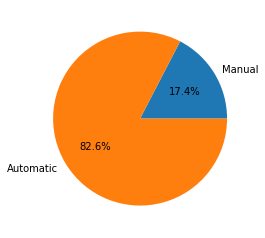

In [15]:
sizes = [ data['Manual'].sum(), len(data['Manual']) ]
labels = ['Manual','Automatic']
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.show()

Drivetrains were broken down into: Front Wheel Drive, Rear Wheel Drive, All Wheel Drive and Four Wheel Drive. There were a few vehicles listed as Two Wheel Drive that were excluded since it could not be determined whether they were Front or Rear Wheel Drive.

In [16]:
Counter(data['Drivetrain'])

Counter({'Front Wheel Drive': 6674,
         'All Wheel Drive': 3448,
         '4 Wheel Drive': 260,
         'Rear Wheel Drive': 4312,
         'All-Wheel Drive': 404,
         'Front-Wheel Drive': 185,
         'All wheel drive': 21,
         'All-wheel drive': 6,
         'AWD': 38,
         'Four Wheel Drive': 1715,
         '2WD': 9,
         '4-Wheel Drive': 1675,
         'RWD': 3,
         'REAR WHEEL DRIVE': 15,
         '4WD': 17,
         'Rear wheel drive': 59,
         'Front wheel drive': 43,
         'Four-Wheel Drive': 45,
         'Front-wheel drive': 6,
         'Four wheel drive': 13,
         '2-Wheel Drive': 8,
         '2 Wheel Drive': 22,
         'Rear-Wheel Drive': 12,
         '4-wheel Drive': 1})

In [17]:
data['Front_Wheel_Drive'] = data['Drivetrain'].str.startswith('Front')
data['Rear_Wheel_Drive']  = data['Drivetrain'].str.startswith('R')
data['All_Wheel_Drive']   = data['Drivetrain'].str.startswith('A')
data['Four_Wheel_Drive']  = data['Drivetrain'].str.startswith('Four') | data['Drivetrain'].str.startswith('4')

In [18]:
missing = data.loc[:,['Front_Wheel_Drive','Rear_Wheel_Drive','All_Wheel_Drive','Four_Wheel_Drive']].sum(axis=1)==0
Counter(missing)

Counter({False: 18952, True: 39})

In [19]:
data = data.drop(data[missing].index)

Front wheel drive vehicles accounted for about 36% of vehicles with rear wheel drive, all wheel drive and four wheel drive constituting about between 20-23% each.

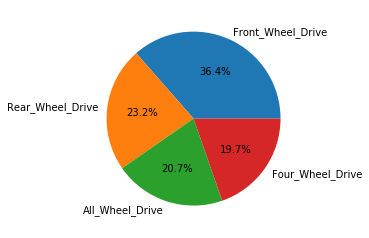

In [20]:
plt.pie(data.iloc[:,-4:].sum().values, labels=data.iloc[:,-4:].columns.values, autopct='%1.1f%%')
plt.show()

Body styles were divided into: SUV, Sedan, Coupe, Station Wagon, Truck and Van. While there were a significant number of Convertibles as well, most of these lacked some of the other data features so these were left out.

In [21]:
Counter(data['Body Style'])

Counter({'Sport Utility': 6047,
         '4dr Car': 6011,
         '2dr Car': 1324,
         'Station Wagon': 880,
         'Convertible': 371,
         'Crew Cab Pickup - Short Bed': 1234,
         'Extended Cab Pickup - Standard Bed': 594,
         'Crew Cab Pickup - Standard Bed': 594,
         'Extended Cab Pickup - Long Bed': 424,
         'Extended Cab Pickup - Short Bed': 790,
         'Full-size Passenger Van': 95,
         'Mini-van, Passenger': 404,
         'Extended Cab Pickup': 2,
         'Crew Cab Pickup - Long Bed': 145,
         '3dr Car': 30,
         'Hatchback': 6,
         'Crew Cab Pickup': 1})

In [22]:
data['SUV'] = data['Body Style'].str.contains('Sport Utility',case=False,regex=False)
data['Sedan'] = data['Body Style'].str.contains('4dr Car',case=False,regex=False)
data['Coupe'] = data['Body Style'].str.contains('2dr Car',case=False,regex=False)
data['Station_Wagon'] = data['Body Style'].str.contains('Station Wagon',case=False,regex=False)
data['Truck'] = data['Body Style'].str.contains('Cab',case=False,regex=False)
data['Van'] = data['Body Style'].str.contains('Pickup',case=False,regex=False)

In [23]:
missing = data.loc[:,['SUV','Sedan','Coupe','Station_Wagon','Truck','Van']].sum(axis=1)==0
Counter(missing)

Counter({False: 18046, True: 906})

In [24]:
data = data.drop(data[missing].index)

Both trucks and vans comprised about 24% of all vehicles each while cars accounted for about 52%.

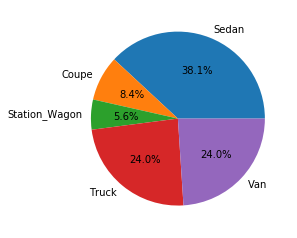

In [25]:
plt.pie(data.iloc[:,-5:].sum().values, labels=data.iloc[:,-5:].columns.values, autopct='%1.1f%%')
plt.show()

In [26]:
data = data.drop(columns=['Drivetrain','Body Style','Trans Description Cont.'])

#### Continuous Variables

From the feature correlation chart, there are definitely some high correlations between continuous variables but these were left in to begin with to be handled by the models.

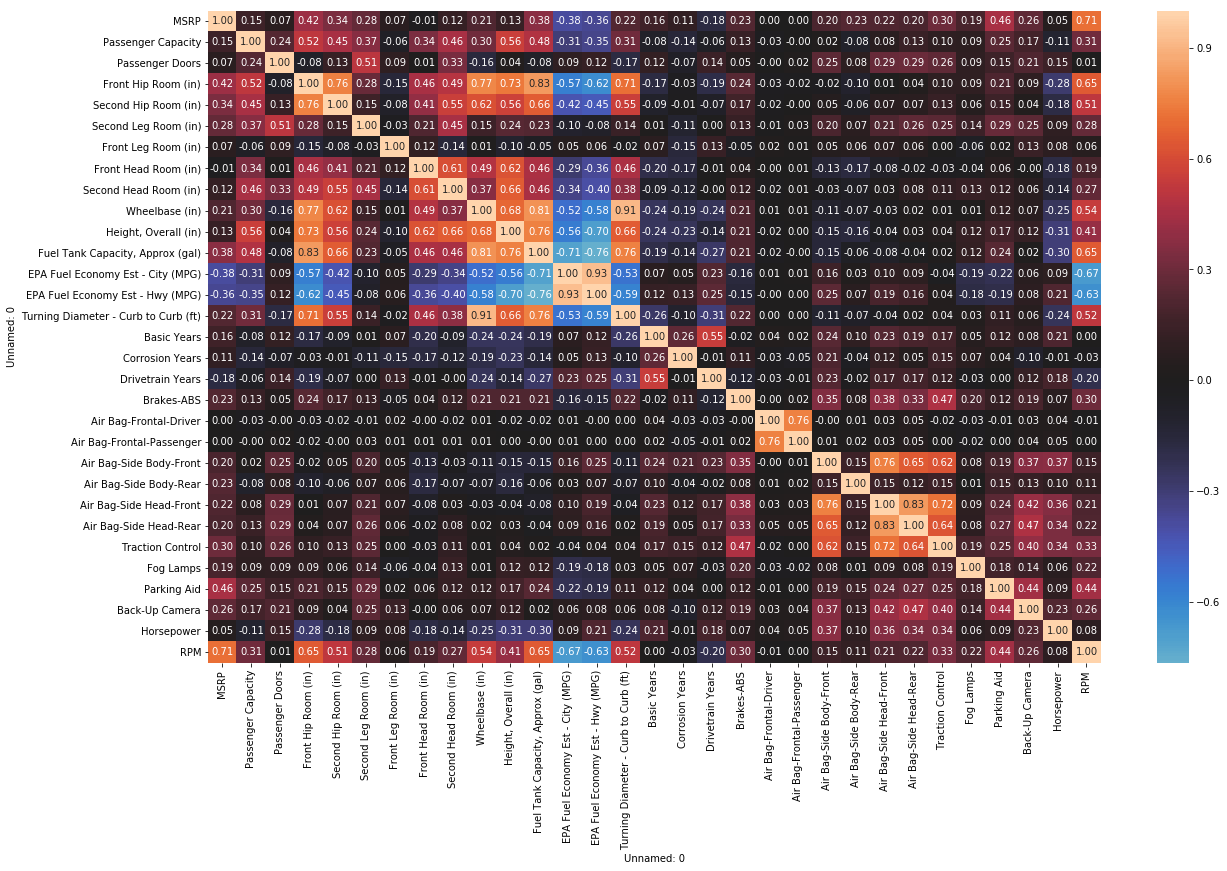

In [28]:
plt.figure(figsize=(20,12))
sns.heatmap(data[numeric_cols].corr(),annot=True,center=0, fmt='0.2f')
plt.show()

After the number of data features has been winnowed, all rows with missing data were dropped, leaving about 14,500 vehicles. This is just under half of the original data set but should still be demonstrative. It is likely that this has increased bias towards specific manufacturers, however, since missing data is probably prevalent across each manufacturer's vehicles.

In [30]:
data.dropna().shape

(14553, 42)

In [32]:
data = data.dropna()

### Research Plan
Due to the number of features remaining and the correlations between some of them, principal component analysis (PCA) was first applied to reduce dimensionality.

A combination of GridSearchCV and model-specific cross validation functions from the scikit-learn toolbox was used for the following models:
- K-Nearest Neighbor
- Decision Tree
- Random Forest
- Ordinary Least Squares Regression
- Ridge Regression
- Lasso Regression
- Support Vector Regression
- Gradient Boosted Regression

Once optimal hyperparameter sets were found, cross validation was performed on the best estimators for each model comparing the training set, test set and full set of data to compare $R^2$ scores across folds.

#### Model Cross Validation Score function
Since model comparisons will be similar, a cross validation score function was written. It performs cross validation using a given model estimator on the training set, the test set and the combined set. A boxplot comparing the $R^{2}$ scores for each fold is also generated.

In [255]:
def model_cv_scores(model_estimator, X_train, Y_train, X_test, Y_test, cv_folds=12, show_graph=True, graph_title=''):
    
    import pandas as pd
    import numpy as np
    from matplotlib import pyplot as plt
    %matplotlib inline
    import seaborn as sns

    # Convert array to DataFrame if necessary so that later functions apply
    if ~isinstance(X_train,pd.DataFrame):
        X_train = pd.DataFrame(data=X_train)
        X_test = pd.DataFrame(data=X_test)
        Y_train = pd.DataFrame(data=Y_train)
        Y_test = pd.DataFrame(data=Y_test)    
    
    X = X_train.append(X_test)
    Y = Y_train.append(Y_test)
    
    # Calculate cross-val scores for training, test and full sets independently
    score_train = cross_val_score(model_estimator, X_train, Y_train, cv=cv_folds, n_jobs=5)
    score_test = cross_val_score(model_estimator, X_test, Y_test, cv=cv_folds, n_jobs=5)
    score_full = cross_val_score(model_estimator, X, Y, cv=cv_folds, n_jobs=5)
    
    # Generate graphs
    if show_graph==True:
        # Generate graphs
        plot_DataFrame = pd.DataFrame(data={'Training': score_train, 'Test': score_test, 'Full': score_full})

        # Create boxplot comparing R^2 scores
        plt.figure
        sns.boxplot(data=plot_DataFrame)
        plt.title('{}\nCross Validation ({} folds): R\u00b2'.format(graph_title,cv_folds))
        plt.ylabel('R\u00b2')
        plt.show()

        # Create KDE plot showing residuals
        plt.figure
        resids = np.subtract(Y.values,model_estimator.predict(X))
        g = sns.jointplot(model_estimator.predict(X), resids, kind='hex', xlim=[0,60000], ylim=[-60000,60000])
        g.set_axis_labels('Projected','Residual')
        g.fig.suptitle('{}\nResiduals'.format(graph_title), y=1.05)
        plt.show()

    # Output best parameters
    if hasattr(model_estimator,'best_params_'):
        print("Best parameters:   {}".format(model_estimator.best_params_))
        
    # Output R^2 means and 95% confidence intervals
    print("R\u00b2 (training set): {0:0.5f} (+/- {1:0.5f})".format(score_train.mean(), score_train.std() * 2))
    print("R\u00b2 (test set):     {0:0.5f} (+/- {1:0.5f})".format(score_test.mean(), score_test.std() * 2))
    print("R\u00b2 (full set):     {0:0.5f} (+/- {1:0.5f})".format(score_full.mean(), score_full.std() * 2))
    
    return score_train, score_test, score_full

### Data Preparation

MSRP was defined as the outcome variable with all of the remaining variables used as predictors.

In [34]:
tgt = data*1
Y = tgt['MSRP']
X = tgt.loc[:, ~tgt.columns.isin(['MSRP'])]

With over 40 variables, some models will take a long time to run. Preferably, a method such as Principal Component Analysis (PCA) could yield comparable results while significantly improving runtimes.

Some methods such as K-Nearest Neighbors (using distance) require equal-scaled variables.

In [35]:
X0_scaled = preprocessing.scale(X)

__main__:1: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by the scale function.


The data were split into a 80% training/20% test set.

In [36]:
X0_train, X0_test, Y0_train, Y0_test = train_test_split(X0_scaled, Y, test_size=0.2)

Performance of the K-Nearest Neighbors model is highly dependent on number of samples when testing. Since initial testing was just used to determine viability of PCA, best estimator was determined using GridSearchCV but cross-validation was not applied on the subsequent model. R^2 score was quite high but runtime was slow.

In [38]:
# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

knn0 = KNeighborsRegressor()
knn_fit0 = GridSearchCV(knn0,{'weights':['uniform','distance'],'n_neighbors':range(1,5)},cv=5,n_jobs=5).fit(X0_train, Y0_train)
print("K-Nearest Neighbors R\u00b2 score {0:0.5f}: ".format(r2_score(Y0_test, knn_fit0.predict(X0_test))))

K-Nearest Neighbors R² score 0.94362: 


### Principal Component Analysis

Looking at the PCA results, about half of variance is explained within the first four components with each of the first ten components explaining at least 2.5% of variance.

__main__:1: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by the scale function.


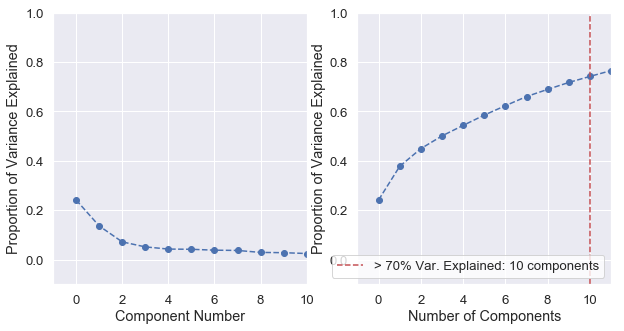

C:\Users\yfsta\Anaconda3\lib\site-packages\matplotlib\__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
C:\Users\yfsta\Anaconda3\lib\site-packages\matplotlib\__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


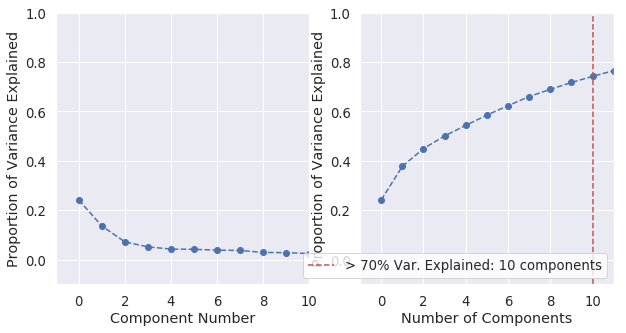

In [94]:
X_scaled = preprocessing.scale(X)
pca = PCA(n_components=20).fit(X_scaled)
plots.plot_scree(pca, required_var=0.7)

In [92]:
pca = PCA(n_components=10).fit(X_scaled)
X_pca_raw = pca.transform(X_scaled)
X_pca = pd.DataFrame(data=X_pca_raw,index=X.index)

The data were split into a 80% training/20% test set.

In [42]:
X_train, X_test, Y_train, Y_test = train_test_split(X_pca, Y, test_size=0.2)

Applying the K-Nearest Neighbors model again using the reduced data set actually yields a higher $R^2$ value, suggesting using PCA with the first ten principal components is a suitable means of reducing dimensionality. Cross-validation was applied later to support these results.

In [43]:
# K Nearest Neighbors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

knn = KNeighborsRegressor()
knn_fit = GridSearchCV(knn,{'weights':['uniform','distance'],'n_neighbors':range(1,5)},cv=5,n_jobs=5).fit(X_train, Y_train)
print("K-Nearest Neighbors (PCA) R\u00b2 score: {0:0.5f}".format(r2_score(Y_test, knn_fit.predict(X_test))))

K-Nearest Neighbors (PCA) R² score: 0.94952


### K-Nearest Neighbors
GridSearchCV was used to determine optimal hyperparameters:

|Parameter|Range/Options|Optimal
|-|-|-
|n_neighbors|1-5|4
|weights|uniform/distance|distance

Both the training and full sets have relatively high $R^2$ values with a tight range among folds but this falls, with a significantly wider range when comparing the test set.

|Set|Mean|95% CI
|-|-|-
|Training|0.93981|0.04599
|Test|0.84932|0.15626
|Full|0.95004|0.04105

In [44]:
# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

knn = KNeighborsRegressor()
knn_fit = GridSearchCV(knn,{'weights':['uniform','distance'],'n_neighbors':range(1,5)},cv=5,n_jobs=5).fit(X_train, Y_train)

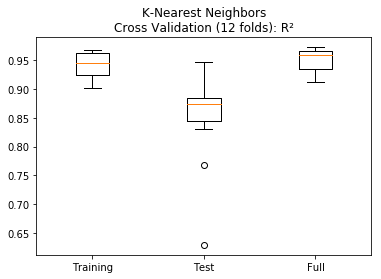

Best parameters:   {'n_neighbors': 4, 'weights': 'distance'}
R² (training set): 0.93981 (+/- 0.04599)
R² (test set):     0.84932 (+/- 0.15626)
R² (full set):     0.95004 (+/- 0.04105)


In [49]:
knn_train, knn_test, knn_full = model_cv_scores(knn_fit, X_train, Y_train, X_test, Y_test, 12, True, 'K-Nearest Neighbors')

### Decision Tree
GridSearchCV was used to determine optimal hyperparameters:

|Parameter|Range/Options|Optimal
|-|-|-
|max_depth|1-8|7
|max_features|1-10|9

The Decision Tree model performs worse than the K-Nearest Neighbors model and there appear to be at least one outlier fold.

|Set|Mean|95% CI
|-|-|-
|Training|0.78192|0.15448
|Test|0.62573|0.47900
|Full|0.77568|0.11811

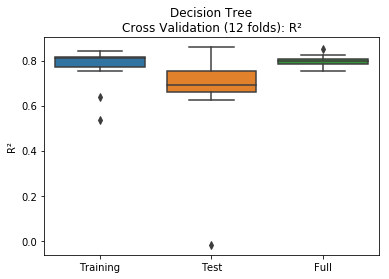

IndexError: too many indices for array

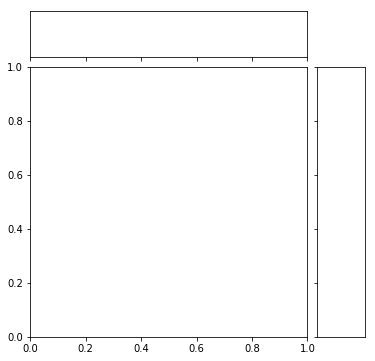

In [256]:
# Decision Tree
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor()
grid_values = {'max_features': range(1,10),'max_depth':range(1,8)}
dt_fit = GridSearchCV(dt, param_grid = grid_values,cv=5,iid=True,n_jobs=5).fit(X_train, Y_train)

dt_train, dt_test, dt_full = model_cv_scores(dt_fit, X_train, Y_train, X_test, Y_test, 12, True, 'Decision Tree')

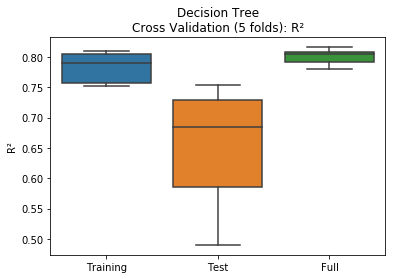

(14553, 1)
(14553,)


IndexError: too many indices for array

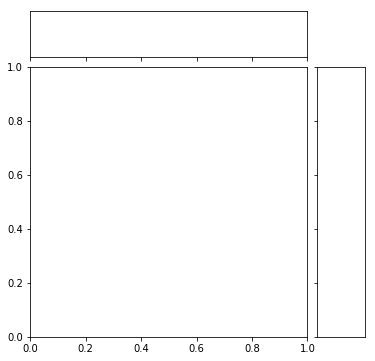

In [254]:
dt_train, dt_test, dt_full = model_cv_scores(dt_fit, X_train, Y_train, X_test, Y_test, 5, True, 'Decision Tree')
#[score_train.T, score_test.T, score_full.T]

#plt.scatter(dt_fit.predict(X_train),np.subtract(Y_train.values,dt_fit.predict(X_train)))


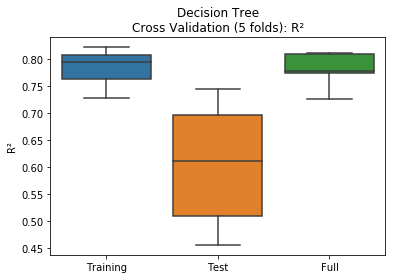

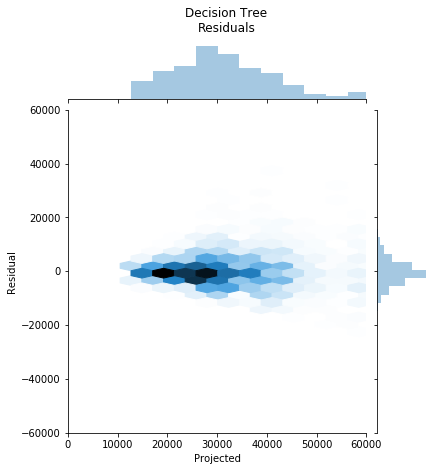

Best parameters:   {'max_depth': 7, 'max_features': 9}
R² (training set): 0.78328 (+/- 0.06688)
R² (test set):     0.60410 (+/- 0.21777)
R² (full set):     0.77994 (+/- 0.06098)


In [257]:
#dt_train, dt_test, dt_full = model_cv_scores(dt_fit, X_train, Y_train, X_test, Y_test, 12, True, 'Decision Tree')
    
# Calculate cross-val scores for training, test and full sets independently
X5 = X_train.append(X_test)
Y5 = Y_train.append(Y_test)

model_estimator = dt_fit
score_train = cross_val_score(model_estimator, X_train, Y_train, cv=5, n_jobs=5)
score_test = cross_val_score(model_estimator, X_test, Y_test, cv=5, n_jobs=5)
score_full = cross_val_score(model_estimator, X5, Y5, cv=5, n_jobs=5)

# Generate graphs
plot_DataFrame = pd.DataFrame(data={'Training': score_train, 'Test': score_test, 'Full': score_full})

# Create boxplot comparing R^2 scores
plt.figure
sns.boxplot(data=plot_DataFrame)
plt.title('{}\nCross Validation ({} folds): R\u00b2'.format('Decision Tree',5))
plt.ylabel('R\u00b2')
plt.show()

# Create KDE plot showing residuals
plt.figure
resids = np.subtract(Y_train.values,model_estimator.predict(X_train))
g = sns.jointplot(model_estimator.predict(X_train), resids, kind='hex', xlim=[0,60000], ylim=[-60000,60000])
g.set_axis_labels('Projected','Residual')
g.fig.suptitle('{}\nResiduals'.format('Decision Tree'), y=1.05)
plt.show()

# Output best parameters
if hasattr(model_estimator,'best_params_'):
    print("Best parameters:   {}".format(model_estimator.best_params_))

# Output R^2 means and 95% confidence intervals
print("R\u00b2 (training set): {0:0.5f} (+/- {1:0.5f})".format(score_train.mean(), score_train.std() * 2))
print("R\u00b2 (test set):     {0:0.5f} (+/- {1:0.5f})".format(score_test.mean(), score_test.std() * 2))
print("R\u00b2 (full set):     {0:0.5f} (+/- {1:0.5f})".format(score_full.mean(), score_full.std() * 2))

### Random Forest
To increase accuracy, n_estimators was increased to 100 and then GridSearchCV was used to determine optimal hyperparameters:

|Parameter|Range/Options|Optimal
|-|-|-
|max_depth|2-5|4
|max_features|3-7|6

The Random Forest model performs worse than either of the two previous models. It also appears to have an outlier fold.

|Set|Mean|95% CI
|-|-|-
|Training|0.65921|0.09672
|Test|0.66615|0.16825
|Full|0.67458|0.10379

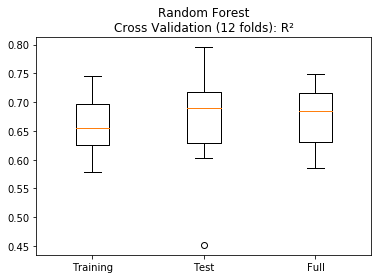

Best parameters:   {'max_depth': 4, 'max_features': 6, 'n_estimators': 100}
R² (training set): 0.65921 (+/- 0.09672)
R² (test set):     0.66615 (+/- 0.16825)
R² (full set):     0.67458 (+/- 0.10379)


In [51]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()

grid_values = {'n_estimators': [100], 'max_features': range(3,7),'max_depth':range(2,5)}
rf_fit = GridSearchCV(rf, param_grid = grid_values,cv=5,iid=True,n_jobs=5).fit(X_train, Y_train)

rf_train, rf_test, rf_full = model_cv_scores(rf_fit, X_train, Y_train, X_test, Y_test, 12, True, 'Random Forest')

### Ordinary Least Squares Regression
The OLS model performs comparably to Random Forest but worse than either of the two previous models.

|Set|Mean|95% CI
|-|-|-
|Training|0.64351|0.06620
|Test|0.67233|0.12059
|Full|0.64881|0.06917

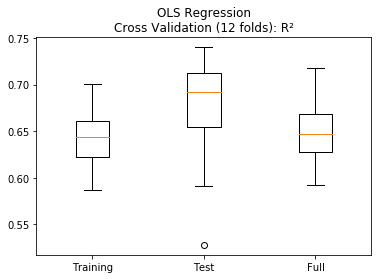

R² (training set): 0.64351 (+/- 0.06620)
R² (test set):     0.67233 (+/- 0.12059)
R² (full set):     0.64881 (+/- 0.06917)


In [52]:
# Ordinary Least Squares Regression
from sklearn.linear_model import LinearRegression
ols_fit = LinearRegression(n_jobs=5).fit(X_train, Y_train)

ols_train, ols_test, ols_full = model_cv_scores(ols_fit, X_train, Y_train, X_test, Y_test, 12, True, 'OLS Regression')

### Ridge Regression
RidgeCV was used to determine optimal alpha:

|Parameter|Range/Options|Optimal
|-|-|-
|alpha|1e-3...1e3|10

The Ridge regression performs similarly to the OLS model.

|Set|Mean|95% CI
|-|-|-
|Training|0.64355|0.06650
|Test|0.67261|0.12164
|Full|0.64883|0.06933

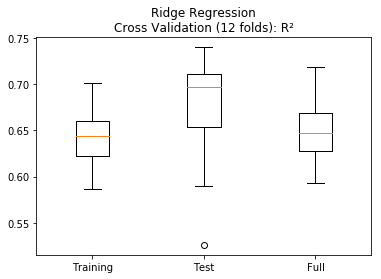

R² (training set): 0.64355 (+/- 0.06650)
R² (test set):     0.67261 (+/- 0.12164)
R² (full set):     0.64883 (+/- 0.06933)
Best alpha: 100.0


In [53]:
# Ridge Regression
from sklearn.linear_model import RidgeCV
ridge_fit = RidgeCV(cv=10,alphas=[1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]).fit(X_train, Y_train)

ridge_train, ridge_test, ridge_full = model_cv_scores(ridge_fit, X_train, Y_train, X_test, Y_test, 12, True, 'Ridge Regression')
print('Best alpha: {}'.format(ridge_fit.alpha_))

### Lasso Regression
LassoCV was used to determine optimal alpha:

|Parameter|Range/Options|Optimal
|-|-|-
|alpha|eps=1e-4|230

The Ridge regression performs similarly to the OLS and Ridge regression models.

|Set|Mean|95% CI
|-|-|-
|Training|0.64352|0.06623
|Test|0.67214|0.12099
|Full|0.64881|0.06919

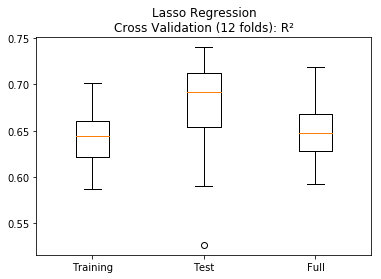

R² (training set): 0.64352 (+/- 0.06623)
R² (test set):     0.67214 (+/- 0.12099)
R² (full set):     0.64881 (+/- 0.06919)
Best alpha: 1.8263229749763208


In [54]:
# Lasso Regression
from sklearn.linear_model import LassoCV
lasso_fit = LassoCV(cv=10,eps=1e-4).fit(X_train, Y_train)

lasso_train, lasso_test, lasso_full = model_cv_scores(lasso_fit, X_train, Y_train, X_test, Y_test, 12, True, 'Lasso Regression')
print('Best alpha: {}'.format(lasso_fit.alpha_))

### Support Vector Regression
GridSearch was used to determine optimal kernel, C and epsilon:

|Parameter|Range/Options|Optimal
|-|-|-
|kernel|'rbf','linear|'linear'
|C|0.1,1|1
|epsilon|0.1,0.2|0.2

The Ridge regression performs similarly to the OLS and Ridge regression models.

|Set|Mean|95% CI
|-|-|-
|Training|0.53687|0.08993
|Test|0.44460|0.14071
|Full|0.55449|0.08066

Best parameters:   {'C': 1, 'epsilon': 0.2, 'kernel': 'linear'}
R² (training set): 0.53687 (+/- 0.08993)
R² (test set):     0.44460 (+/- 0.14071)
R² (full set):     0.55449 (+/- 0.08066)

C:\Users\yfsta\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\yfsta\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\yfsta\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\yfsta\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706

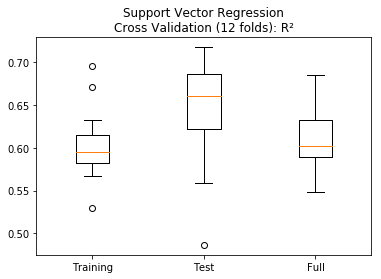

Best parameters:   {'C': 1000, 'epsilon': 0.2, 'kernel': 'linear'}
R² (training set): 0.60326 (+/- 0.08655)
R² (test set):     0.64497 (+/- 0.12859)
R² (full set):     0.60919 (+/- 0.07949)


In [61]:
# Linear Support Vector Regressor
from sklearn.svm import SVR
svr = SVR(gamma='scale')
grid_values = {'C': [1,10,100,1000], 'epsilon': [0.1,0.2,0.3], 'kernel': ['linear']}
svr_fit = GridSearchCV(svr, param_grid = grid_values,cv=5,iid=True,n_jobs=5).fit(X_train,Y_train)

svr_train, svr_test, svr_full = model_cv_scores(svr_fit, X_train, Y_train, X_test, Y_test, 12, True, 'Support Vector Regression')

C:\Users\yfsta\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\yfsta\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\yfsta\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\yfsta\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706

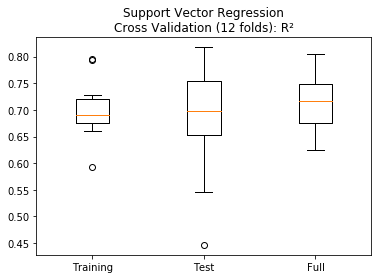

Best parameters:   {'C': 1000, 'epsilon': 0.1, 'kernel': 'rbf'}
R² (training set): 0.70067 (+/- 0.10618)
R² (test set):     0.68380 (+/- 0.19992)
R² (full set):     0.71775 (+/- 0.10461)


In [62]:
# Support Vector Regressor
from sklearn.svm import SVR
svr = SVR(gamma='scale')
grid_values = {'C': [100,1000,10000], 'epsilon': [0.05,0.1,0.15,], 'kernel': ['rbf']}
svr_fit = GridSearchCV(svr, param_grid = grid_values,cv=5,iid=True,n_jobs=5).fit(X_train,Y_train)

svr_train, svr_test, svr_full = model_cv_scores(svr_fit, X_train, Y_train, X_test, Y_test, 12, True, 'Support Vector Regression')

In [ ]:
# Gradient Boosting Regressor
from sklearn.ensemble import GradientBoostingRegressor

params = {'n_estimators': 500,
          'max_depth': 3}

# Initialize and fit the model.
gb_fit = GradientBoostingRegressor(**params).fit(X_train, Y_train)

gb_train, gb_test, gb_full = model_cv_scores(gb_fit, X_train, Y_train, X_test, Y_test, 12, True, 'Gradient Boosting Regression')

## Sedans Only

Of the categorical variables included, body style may be the most relevant to consumers as different body styles have different functionalities. For example, a sedan is more likely to be used as a family car while a truck may be used for hauling. Since sedan is the most common body style, models were run again on a sedan-only data set to determine whether body style affected optimal model.

### Data Preparation

The sedan subset was selected.

In [ ]:
tgt2 = data.query('Sedan == True')

MSRP was defined as the outcome variable with all of the remaining variables used as predictors.

In [ ]:
Y2 = tgt2['MSRP']
X2 = tgt2.loc[:, ~tgt2.columns.isin(['MSRP','SUV','Sedan','Coupe','Station_Wagon','Truck','Van'])]

### Principal Component Analysis

Looking at the PCA results, about half of variance is explained within the first four components with each of the first ten components explaining at least 3.0% of variance.

In [ ]:
X2_scaled = preprocessing.scale(X2)
pca2 = PCA(n_components=10).fit(X2_scaled)
pca2.explained_variance_ratio_

In [ ]:
X2_pca_raw = pca.transform(X2_scaled)
X2_pca = pd.DataFrame(data=X2_pca_raw,index=X2.index)

The data were split into a 80% training/20% test set.

In [ ]:
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2_pca, Y2, test_size=0.2)

### K-Nearest Neighbors
GridSearchCV was used to determine optimal hyperparameters:

|Parameter|Range/Options|Optimal
|-|-|-
|n_neighbors|1-5|3
|weights|uniform/distance|distance

Both the training and full sets have relatively high $R^2$ values with a tight range among folds but this falls, with a significantly wider range when comparing the test set.

|Set|Mean|95% CI
|-|-|-
|Training|0.93058|0.04622
|Test|0.81944|0.12264
|Full|0.93559|0.04441

In [ ]:
# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

knn = KNeighborsRegressor()
knn_fit2 = GridSearchCV(knn,{'weights':['uniform','distance'],'n_neighbors':range(1,5)},cv=5,n_jobs=5).fit(X2_train, Y2_train)

In [ ]:
knn_train2, knn_test2, knn_full2 = model_cv_scores(knn_fit2, X2_train, Y2_train, X2_test, Y2_test, 12, True, 'K-Nearest Neighbors (Cars)')

### Decision Tree
GridSearchCV was used to determine optimal hyperparameters:

|Parameter|Range/Options|Optimal
|-|-|-
|max_depth|1-8|7
|max_features|1-10|7

The Decision Tree model performs worse than the K-Nearest Neighbors model, although the results of the test set are more consistent to the training set.

|Set|Mean|95% CI
|-|-|-
|Training|0.79843|0.06719
|Test|0.74166|0.19937
|Full|0.81530|0.04257

In [ ]:
# Decision Tree
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor()
grid_values = {'max_features': range(1,10),'max_depth':range(1,8)}
dt_fit2 = GridSearchCV(dt, param_grid = grid_values,cv=5,iid=True,n_jobs=5).fit(X2_train, Y2_train)

dt_train2, dt_test2, dt_full2 = model_cv_scores(dt_fit, X2_train, Y2_train, X2_test, Y2_test, 12, True, 'Decision Tree (Cars)')

### Random Forest
To increase accuracy, n_estimators was increased to 100 and then GridSearchCV was used to determine optimal hyperparameters:

|Parameter|Range/Options|Optimal
|-|-|-
|max_depth|2-5|4
|max_features|3-7|6

The Random Forest model performs worse than either of the two previous models, although it does have the tighest 95% confidence intervals.

|Set|Mean|95% CI
|-|-|-
|Training|0.71925|0.04571
|Test|0.68989|0.09619
|Full|0.72416|0.04512

In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()

grid_values = {'n_estimators': [100], 'max_features': range(3,7),'max_depth':range(2,5)}
rf_fit2 = GridSearchCV(rf, param_grid = grid_values,cv=5,iid=True,n_jobs=5).fit(X2_train, Y2_train)

rf_train2, rf_test2, rf_full2 = model_cv_scores(rf_fit2, X2_train, Y2_train, X2_test, Y2_test, 12, True, 'Random Forest (Cars)')

### Ordinary Least Squares Regression
The OLS model performs comparably to Random Forest but worse than either of the two previous models.

|Set|Mean|95% CI
|-|-|-
|Training|0.67846|0.03753
|Test|0.66948|0.10856
|Full|0.67608|0.03619

In [ ]:
# Ordinary Least Squares Regression
from sklearn.linear_model import LinearRegression
ols_fit2 = LinearRegression(n_jobs=5).fit(X2_train, Y2_train)

ols_train2, ols_test2, ols_full2 = model_cv_scores(ols_fit2, X2_train, Y2_train, X2_test, Y2_test, 12, True, 'OLS Regression (Cars)')

### Ridge Regression
RidgeCV was used to determine optimal alpha:

|Parameter|Range/Options|Optimal
|-|-|-
|alpha|1e-3...1e3|10

The Ridge regression performs similarly to the OLS model.

|Set|Mean|95% CI
|-|-|-
|Training|0.67846|0.03753
|Test|0.66930|0.10859
|Full|0.67608|0.03617

In [ ]:
# Ridge Regression
from sklearn.linear_model import RidgeCV
ridge_fit2 = RidgeCV(cv=10,alphas=[1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]).fit(X2_train, Y2_train)

ridge_train2, ridge_test2, ridge_full2 = model_cv_scores(ridge_fit2, X2_train, Y2_train, X2_test, Y2_test, 12, True, 'Ridge Regression (Cars)')
print('Best alpha: {}'.format(ridge_fit2.alpha_))

### Lasso Regression
LassoCV was used to determine optimal alpha:

|Parameter|Range/Options|Optimal
|-|-|-
|alpha|eps=1e-4|230

The Ridge regression performs similarly to the OLS and Ridge regression models.

|Set|Mean|95% CI
|-|-|-
|Training|0.67496|0.03709
|Test|0.66739|0.10773
|Full|0.67277|0.03593

In [ ]:
# Lasso Regression
from sklearn.linear_model import LassoCV
lasso_fit2 = LassoCV(cv=10,eps=1e-4).fit(X2_train, Y2_train)

lasso_train2, lasso_test2, lasso_full2 = model_cv_scores(lasso_fit2, X2_train, Y2_train, X2_test, Y2_test, 12, True, 'Lasso Regression (Cars)')
print('Best alpha: {}'.format(lasso_fit2.alpha_))

Initial observations from the Lasso regression coefficients:
- Consumers do not want to refuel often: both higher fuel tank capacity and in city mileage are important.
- Leg room appears to be the most important 'roominess' factor.
- Head room does not seem important. Although it has a negative coefficient, it is probably partly offset by the leg room coeffiients.
- The negative sign for wheelbase suggests that consumers prefer shorter cars. However, this would seem to suggest less leg room (at least in the rear) so this may also be partially offset by leg room.
- Mathematically, Horsepower = Torque x RPM / 5252. Although RPM and Horsepower have opposite signs, RPM more than offsets the corresponding change in Horsepower.

In [ ]:
lasso_coefs = pd.DataFrame(lasso_fit.coef_, index=X.columns,
                                   columns=['Coefficient']).sort_values('Coefficient', ascending=False)
print(lasso_coefs)

Looking at correlations:
- Leg room does not actually appear to be correlated with any of the other variables (including front vs. second leg room).
- RPM looks completely uncorrelated to horsepower.
- There is a fairly high negative relationship between fuel tank capacity and city MPG suggesting a target 'miles per tank' so an ideal car would have both.

In [ ]:
sns.heatmap(X.loc[:,['Fuel Tank Capacity, Approx (gal)','EPA Fuel Economy Est - City (MPG)',\
        'Second Leg Room (in)','Front Leg Room (in)','RPM','Horsepower','Front Head Room (in)','Wheelbase (in)']].corr(),\
        annot=True,center=0, fmt='0.2f')

In [ ]:
# Support Vector Regressor
from sklearn.svm import SVR
svr = SVR(kernel = 'rbf', gamma='scale')
grid_values = {'C': [1], 'epsilon': [0.1]}
svr_fit = GridSearchCV(svr, param_grid = grid_values,cv=5,iid=True,n_jobs=5).fit(X_train,Y_train)

svr_train, svr_test, svr_full = model_cv_scores(svr_fit, X_train, Y_train, X_test, Y_test, 12, True, 'Support Vector Regression')

In [ ]:
# Linear Support Vector Regressor
from sklearn.svm import LinearSVR
lin_svr_fit = LinearSVR(max_iter=10000).fit(X_train,Y_train)

lin_svr_train, lin_svr_test, lin_svr_full = model_cv_scores(lin_svr_fit, X_train, Y_train, X_test, Y_test, 12, True, 'Linear Support Vector Regression')

In [ ]:
# Gradient Boosting Regressor
from sklearn.ensemble import GradientBoostingRegressor

params = {'n_estimators': 500,
          'max_depth': 3}

# Initialize and fit the model.
gb_fit2 = GradientBoostingRegressor(**params).fit(X2_train, Y2_train)

gb_train2, gb_test2, gb_full2 = model_cv_scores(gb_fit2, X2_train, Y2_train, X2_test, Y2_test, 12, True, 'Gradient Boosting Regression (Cars)')

### K-Nearest Neighbors by Body Style

The K-Nearest Neighbors model performed well in both the full and sedan-only sets. To determine whether body style affected performance of K-Nearest Neighbors, the model was applied on each individual body style.

In [ ]:
tgt_SUV = data.query('SUV == True')
Y_SUV = tgt_SUV['MSRP']
X_SUV = tgt_SUV.loc[:, ~tgt_SUV.columns.isin(['MSRP'])]

X_SUV_scaled = preprocessing.scale(X_SUV)
pca_SUV = PCA(n_components=10).fit(X_SUV_scaled)
#pca.explained_variance_ratio_
X_SUV_pca_raw = pca_SUV.transform(X_SUV_scaled)
X_SUV_pca = pd.DataFrame(data=X_SUV_pca_raw,index=X_SUV.index)
X_SUV_train, X_SUV_test, Y_SUV_train, Y_SUV_test = train_test_split(X_SUV_pca, Y_SUV, test_size=0.2)

# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

knn = KNeighborsRegressor()
knn_fit_SUV = GridSearchCV(knn,{'weights':['uniform','distance'],'n_neighbors':range(1,5)},cv=5,n_jobs=5).\
    fit(X_SUV_train, Y_SUV_train)
knn_SUV_train, knn_SUV_test2, knn_SUV_full2 = model_cv_scores(knn_fit_SUV, X_SUV_train, Y_SUV_train, \
                                                   X_SUV_test, Y_SUV_test, 12, True, 'K-Nearest Neighbors (SUV)')

In [ ]:
tgt_Sedan = data.query('Sedan == True')
Y_Sedan = tgt_Sedan['MSRP']
X_Sedan = tgt_Sedan.loc[:, ~tgt_Sedan.columns.isin(['MSRP'])]

X_Sedan_scaled = preprocessing.scale(X_Sedan)
pca_Sedan = PCA(n_components=10).fit(X_Sedan_scaled)
#pca.explained_variance_ratio_
X_Sedan_pca_raw = pca_Sedan.transform(X_Sedan_scaled)
X_Sedan_pca = pd.DataFrame(data=X_Sedan_pca_raw,index=X_Sedan.index)
X_Sedan_train, X_Sedan_test, Y_Sedan_train, Y_Sedan_test = train_test_split(X_Sedan_pca, Y_Sedan, test_size=0.2)

# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

knn = KNeighborsRegressor()
knn_fit_Sedan = GridSearchCV(knn,{'weights':['uniform','distance'],'n_neighbors':range(1,5)},cv=5,n_jobs=5).\
    fit(X_Sedan_train, Y_Sedan_train)
knn_Sedan_train, knn_Sedan_test2, knn_Sedan_full2 = model_cv_scores(knn_fit_Sedan, X_Sedan_train, Y_Sedan_train, \
                                                   X_Sedan_test, Y_Sedan_test, 12, True, 'K-Nearest Neighbors (Sedan)')

In [ ]:
tgt_Coupe = data.query('Coupe == True')
Y_Coupe = tgt_Coupe['MSRP']
X_Coupe = tgt_Coupe.loc[:, ~tgt_Coupe.columns.isin(['MSRP'])]

X_Coupe_scaled = preprocessing.scale(X_Coupe)
pca_Coupe = PCA(n_components=10).fit(X_Coupe_scaled)
#pca.explained_variance_ratio_
X_Coupe_pca_raw = pca_Coupe.transform(X_Coupe_scaled)
X_Coupe_pca = pd.DataFrame(data=X_Coupe_pca_raw,index=X_Coupe.index)
X_Coupe_train, X_Coupe_test, Y_Coupe_train, Y_Coupe_test = train_test_split(X_Coupe_pca, Y_Coupe, test_size=0.2)

# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

knn = KNeighborsRegressor()
knn_fit_Coupe = GridSearchCV(knn,{'weights':['uniform','distance'],'n_neighbors':range(1,5)},cv=5,n_jobs=5).\
    fit(X_Coupe_train, Y_Coupe_train)
knn_Coupe_train, knn_Coupe_test2, knn_Coupe_full2 = model_cv_scores(knn_fit_Coupe, X_Coupe_train, Y_Coupe_train, \
                                                   X_Coupe_test, Y_Coupe_test, 12, True, 'K-Nearest Neighbors (Coupe)')

In [ ]:
tgt_SW = data.query('Station_Wagon == True')
Y_SW = tgt_SW['MSRP']
X_SW = tgt_SW.loc[:, ~tgt_SW.columns.isin(['MSRP'])]

X_SW_scaled = preprocessing.scale(X_SW)
pca_SW = PCA(n_components=10).fit(X_SW_scaled)
#pca.explained_variance_ratio_
X_SW_pca_raw = pca_SW.transform(X_SW_scaled)
X_SW_pca = pd.DataFrame(data=X_SW_pca_raw,index=X_SW.index)
X_SW_train, X_SW_test, Y_SW_train, Y_SW_test = train_test_split(X_SW_pca, Y_SW, test_size=0.2)

# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

knn = KNeighborsRegressor()
knn_fit_SW = GridSearchCV(knn,{'weights':['uniform','distance'],'n_neighbors':range(1,5)},cv=5,n_jobs=5).\
    fit(X_SW_train, Y_SW_train)
knn_SW_train, knn_SW_test2, knn_SW_full2 = model_cv_scores(knn_fit_SW, X_SW_train, Y_SW_train, \
                                                   X_SW_test, Y_SW_test, 12, True, 'K-Nearest Neighbors (SW)')

In [ ]:
tgt_Truck = data.query('Truck == True')
Y_Truck = tgt_Truck['MSRP']
X_Truck = tgt_Truck.loc[:, ~tgt_Truck.columns.isin(['MSRP'])]

X_Truck_scaled = preprocessing.scale(X_Truck)
pca_Truck = PCA(n_components=10).fit(X_Truck_scaled)
#pca.explained_variance_ratio_
X_Truck_pca_raw = pca_Truck.transform(X_Truck_scaled)
X_Truck_pca = pd.DataFrame(data=X_Truck_pca_raw,index=X_Truck.index)
X_Truck_train, X_Truck_test, Y_Truck_train, Y_Truck_test = train_test_split(X_Truck_pca, Y_Truck, test_size=0.2)

# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

knn = KNeighborsRegressor()
knn_fit_Truck = GridSearchCV(knn,{'weights':['uniform','distance'],'n_neighbors':range(1,5)},cv=5,n_jobs=5).\
    fit(X_Truck_train, Y_Truck_train)
knn_Truck_train, knn_Truck_test2, knn_Truck_full2 = model_cv_scores(knn_fit_Truck, X_Truck_train, Y_Truck_train, \
                                                   X_Truck_test, Y_Truck_test, 12, True, 'K-Nearest Neighbors (Truck)')

In [ ]:
tgt_Van = data.query('Van == True')
Y_Van = tgt_Van['MSRP']
X_Van = tgt_Van.loc[:, ~tgt_Van.columns.isin(['MSRP'])]

X_Van_scaled = preprocessing.scale(X_Van)
pca_Van = PCA(n_components=10).fit(X_Van_scaled)
#pca.explained_variance_ratio_
X_Van_pca_raw = pca_Van.transform(X_Van_scaled)
X_Van_pca = pd.DataFrame(data=X_Van_pca_raw,index=X_Van.index)
X_Van_train, X_Van_test, Y_Van_train, Y_Van_test = train_test_split(X_Van_pca, Y_Van, test_size=0.2)

# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

knn = KNeighborsRegressor()
knn_fit_Van = GridSearchCV(knn,{'weights':['uniform','distance'],'n_neighbors':range(1,5)},cv=5,n_jobs=5).\
    fit(X_Van_train, Y_Van_train)
knn_Van_train, knn_Van_test2, knn_Van_full2 = model_cv_scores(knn_fit_Van, X_Van_train, Y_Van_train, \
                                                   X_Van_test, Y_Van_test, 12, True, 'K-Nearest Neighbors (Van)')